In [3]:
import pandas as pd
import numpy as np
from gensim.models import Word2Vec
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder
from nltk.tokenize import word_tokenize
import re
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import seaborn as sns

In [8]:
import pandas as pd

# Charger le fichier CSV
df = pd.read_csv('dataset/phrases_emojis.csv')

# Liste pour stocker les nouvelles lignes de données
new_data = []

# Itérer sur chaque ligne du DataFrame
for _, row in df.iterrows():
    phrase = row['Phrase']
    emojis = row['Emojis']
    
    # Séparer les emojis par un espace ou un autre séparateur
    emoji_list = list(emojis)  # Cela sépare chaque emoji dans une liste

    # Ajouter une nouvelle ligne pour chaque emoji
    for emoji in emoji_list:
        if emoji != "" or " ":  # Vérifier que l'emoji n'est pas vide
            new_data.append({"Phrase": phrase, "Emojis": emoji})

# Créer un nouveau DataFrame avec les données traitées
new_df = pd.DataFrame(new_data)

# Supprimer les doublons (phrase, emoji identiques)
new_df = new_df.drop_duplicates()

# Sauvegarder le résultat dans un nouveau fichier CSV
new_df.to_csv('dataset/fichier_transforme.csv', index=False)

# Supprimer les lignes où la colonne "Emojis" est vide ou contient uniquement des espaces
# Supprimer les lignes où "Emojis" est vide, composé uniquement d'espaces ou de caractères invisibles
new_df = new_df[~new_df['Emojis'].str.strip().replace(r'^\s*$', np.nan, regex=True).isna()]


    

print("Le fichier a été transformé avec succès.")





Le fichier a été transformé avec succès.


In [11]:
# Fonction de prétraitement du texte
def preprocess_text(text):
    text = text.lower()  # Convertir en minuscule
    text = re.sub(r'http\S+', '', text)  # Supprimer les liens
    text = re.sub(r'@\w+', '', text)  # Supprimer les mentions
    text = re.sub(r'[^a-zA-Z\s]', '', text)  # Supprimer les caractères non-alphabétiques
    return text

df = pd.read_csv('dataset/fichier_transforme.csv')

# Prétraitement
df['tweet_processed'] = df['Phrase'].apply(preprocess_text)

In [12]:
# Tokenisation des tweets
tokenized_tweets = [word_tokenize(tweet,language="french") for tweet in df['tweet_processed']]

# Entraîner un modèle Word2Vec
model = Word2Vec(sentences=tokenized_tweets, window=3, min_count=1, sg=1,workers=4)

# Sauvegarder le modèle
model.save("models/word2vec_model_twitter.model")
print("Modèle sauvegardé.")

/home/rb/Emoji-Prediction/.venv/lib/python3.12/site-packages/gensim/models/base_any2vec.py:617: UserWarning: C extension not loaded, training will be slow. Install a C compiler and reinstall gensim for fast training.
  warnings.warn(


Modèle sauvegardé.


In [13]:
# Fonction pour obtenir l'embedding moyen d'un tweet
def get_tweet_embedding(tweet, model):
    tokens = word_tokenize(preprocess_text(tweet))  # Tokenisation
    embeddings = []
    
    for word in tokens:
        if word in model.wv:
            embeddings.append(model.wv[word])
    
    if embeddings:
        return np.mean(embeddings, axis=0)  # Renvoie l'embedding moyen
    else:
        return np.zeros(model.vector_size)  # Si aucun mot trouvé dans le modèle, renvoie un vecteur nul

# Extraire les embeddings des tweets
X = np.array([get_tweet_embedding(tweet, model) for tweet in df['Phrase']])

# Encoder les emojis en labels numériques
encoder = LabelEncoder()
df['emoji_label'] = encoder.fit_transform(df['Emojis'])

# Définir les labels (y) et les caractéristiques (X)
y = df['emoji_label'].values

# Diviser les données en ensemble d'entraînement et de test
X_train, X_test, y_train, y_test, train_indices, test_indices = train_test_split(
    X, y, np.arange(len(df)), test_size=0.2, random_state=42)

# Entraîner un modèle de classification (RandomForest ici, mais vous pouvez essayer d'autres modèles)
clf = RandomForestClassifier(n_estimators=800,criterion="gini")
clf.fit(X_train, y_train)


RandomForestClassifier(n_estimators=800)

In [40]:
# Prédiction sur l'ensemble de test
y_pred = clf.predict(X_test)
print(X_test)

# Évaluation de la précision du modèle
accuracy = accuracy_score(y_test, y_pred)
print(f"Précision du modèle : {accuracy * 100:.2f}%")

# Afficher des emojis prédits pour quelques exemples
predicted_emojis = encoder.inverse_transform(y_pred)

# Récupérer les tweets et emojis réels correspondants aux indices de l'ensemble de test
tweets_predicted = df.iloc[test_indices]['Phrase']
emojis_real = df.iloc[test_indices]['Emojis']

# Afficher les résultats : tweet, emoji réel et emoji prédit
for tweet, emoji_real, emoji_pred in zip(tweets_predicted.head(30), emojis_real.head(30), predicted_emojis[:30]):
    print(f"Tweet: {tweet}\nEmoji réel: {emoji_real}\nEmoji prédit: {emoji_pred}\n")


phrase = "rejoignez nous pour le bar à chats"
x_sample=get_tweet_embedding(phrase, model)
y_sample=clf.predict([x_sample])

predicted= encoder.inverse_transform(y_sample)
print(phrase, predicted)


[[ 0.15087913  0.04012975 -0.21996251 ... -0.06105945  0.11014503
   0.15737434]
 [ 0.24147528  0.01134861 -0.18242303 ... -0.14500555 -0.02255096
   0.21850152]
 [ 0.19767703  0.0219658  -0.26456845 ... -0.08881051  0.08853037
   0.13602069]
 ...
 [ 0.03383943  0.07451839 -0.33724165 ... -0.07173903  0.01728166
   0.24972138]
 [ 0.14442974  0.03079    -0.2317989  ... -0.0745837   0.05592347
   0.19363825]
 [ 0.18064693  0.00577305 -0.34323376 ... -0.06803539  0.09489691
   0.22795394]]
Précision du modèle : 5.87%
Tweet: Mister bouboulé dans la place
Emoji réel: 😅
Emoji prédit: 😁

Tweet: à ceux qui pourront m'aider
Emoji réel: 🙂
Emoji prédit: 🇬

Tweet: Hello à toutes et tous
Emoji réel: 👋
Emoji prédit: 😊

Tweet: Mon rêve est de vivre à Marseille .  Pour moi, c'est la meilleure ville de France des 5 grandes villes que j'ai visitées.  Je voulais acheter un appartement à L'Estaque l'année prochaine, pour y faire ma vie.  Je pourrais courir sur la plage tous les jours.  Je serais vraiment 

/home/rb/Emoji-Prediction/.venv/lib/python3.12/site-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(
/tmp/ipykernel_46917/2796133348.py:44: UserWarning: Glyph 9917 (\N{SOCCER BALL}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_46917/2796133348.py:44: UserWarning: Glyph 9961 (\N{SHINTO SHRINE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_46917/2796133348.py:44: UserWarning: Glyph 9962 (\N{CHURCH}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_46917/2796133348.py:44: UserWarning: Glyph 9968 (\N{MOUNTAIN}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_46917/2796133348.py:44: UserWarning: Glyph 9971 (\N{FLAG IN HOLE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_46917/2796133348.py:44: UserWarning: Glyph 9973 (\N{SAILBOAT}) missing from font(s) DejaVu Sans.
  plt.tig

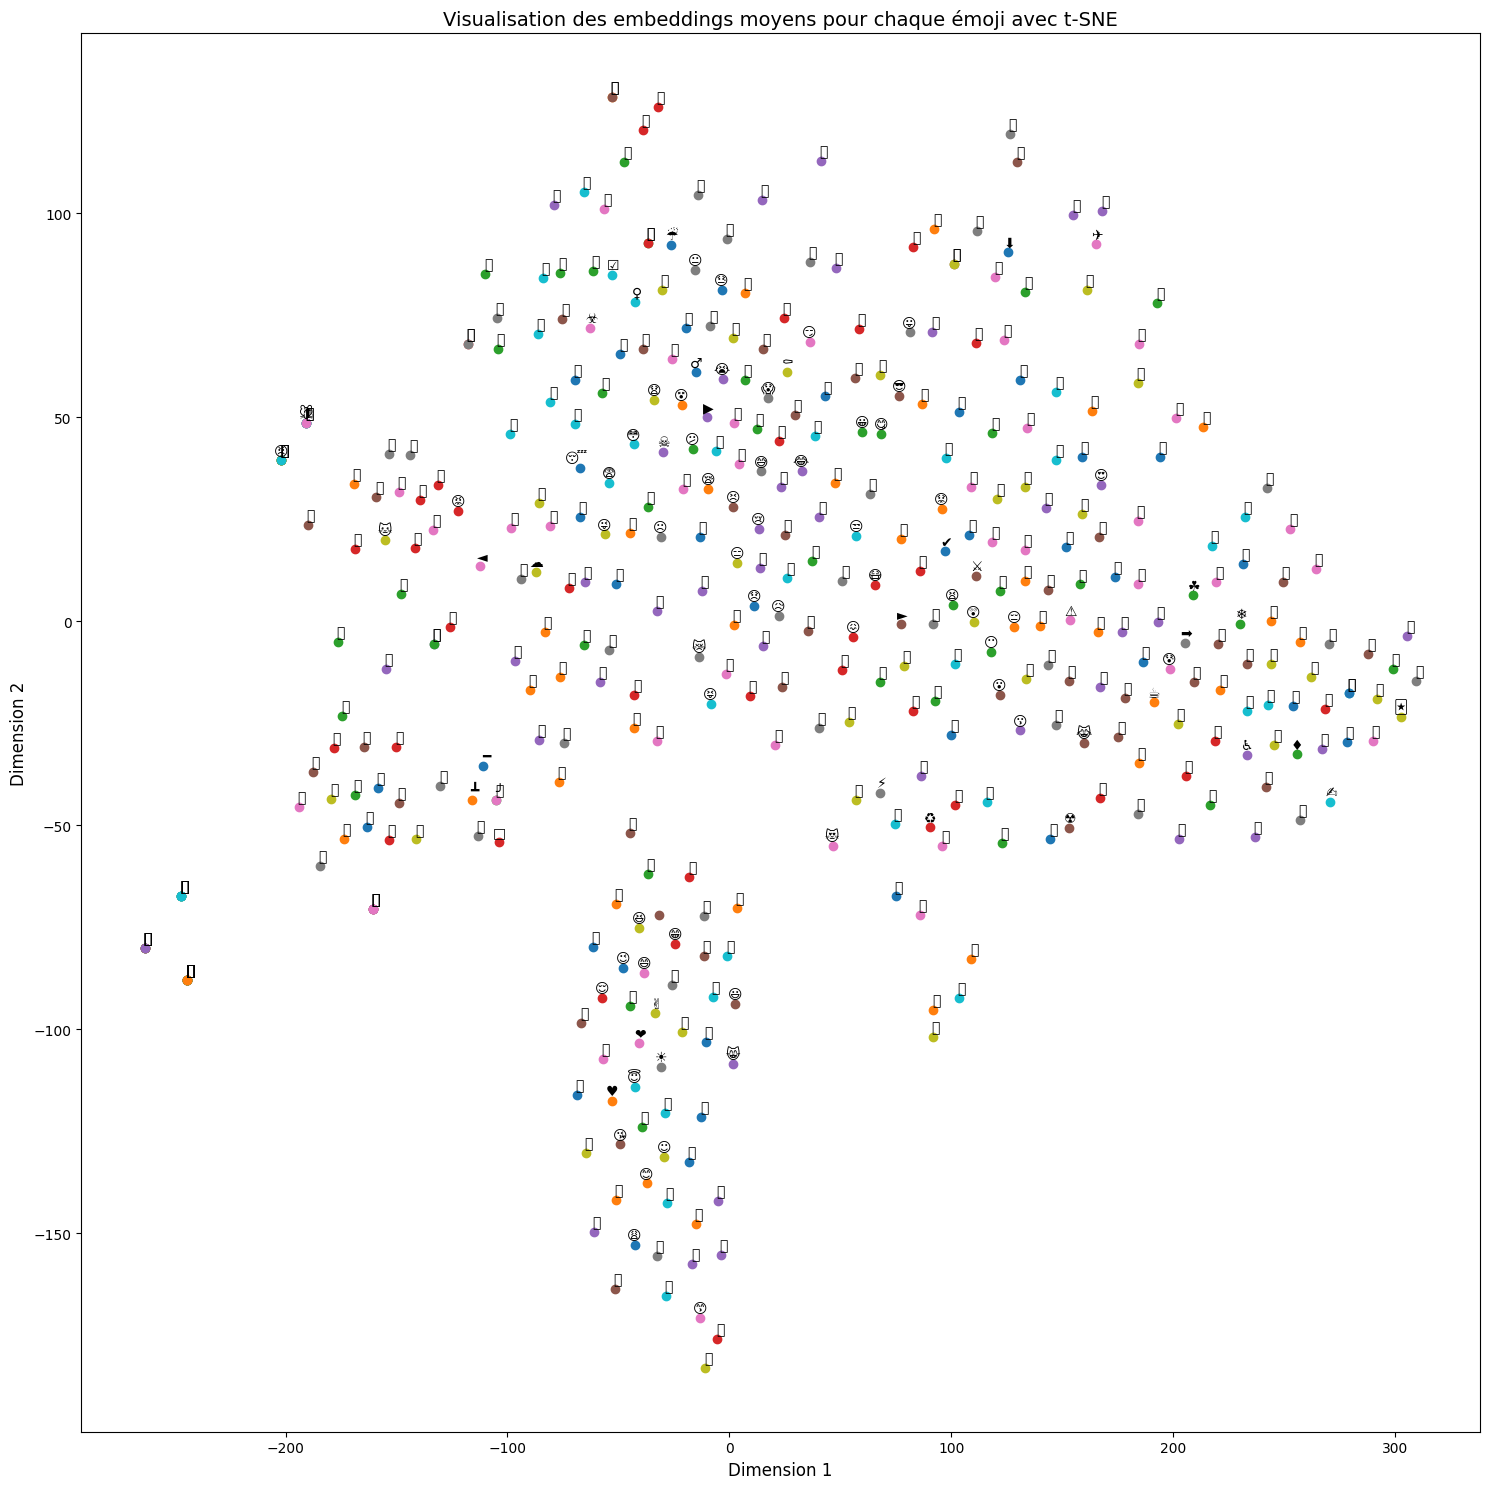

In [23]:
# Calcul des embeddings moyens pour chaque classe d'émojis
class_embeddings = []
labels = []

# Récupérer les émojis uniques (classes)
for emoji_label in np.unique(df['emoji_label']):
    class_tweets = df[df['emoji_label'] == emoji_label]['Phrase']
    class_embedding = np.mean([get_tweet_embedding(tweet, model) for tweet in class_tweets], axis=0)
    class_embeddings.append(class_embedding)
    labels.append(encoder.inverse_transform([emoji_label])[0])  # Ajouter l'émoji correspondant à la classe

# Convertir class_embeddings en un tableau NumPy
class_embeddings = np.array(class_embeddings)

# Appliquer t-SNE pour réduire les dimensions
tsne = TSNE(perplexity=40, n_components=2, init='pca', n_iter=2500, random_state=23)
new_values = tsne.fit_transform(class_embeddings)

# Visualisation
x = new_values[:, 0]
y = new_values[:, 1]

# Créer le graphique
plt.figure(figsize=(15, 15))

# Ajouter les émojis directement sur le graphique
for i in range(len(x)):
    plt.scatter(x[i], y[i])  # Afficher chaque point
    plt.annotate(labels[i],  # Ajouter l'émoji comme annotation
                 xy=(x[i], y[i]), 
                 xytext=(5, 2),  # Décalage de l'annotation
                 textcoords='offset points', 
                 ha='right', 
                 va='bottom', 
            
                 fontsize=10)  # Taille de l'émoji

# Ajouter un titre et des label
plt.title("Visualisation des embeddings moyens pour chaque émoji avec t-SNE", fontsize=14)
plt.xlabel("Dimension 1", fontsize=12)
plt.ylabel("Dimension 2", fontsize=12)

# Sauvegarder l'image
plt.tight_layout()
plt.savefig('t-sne.png')

# Afficher le graphique
plt.show()